# Данные
- train - каждая строка - последовательность id треков, которые лайкнул один пользователь.  
- test - имеет точно такой же формат, но в каждой строке не хватает последнего лайка, который надо предсказать.  
- track_artists.csv - информация о исполнителях треков. Гарантируется, что у каждого трека есть ровно один исполнитель.  
- Файл score.py содержит код, который вы можете использовать, чтобы локально считать mrr для своего решения.  
  
Количество лайкнутых треков у каждого позьзователя разное

In [ ]:
!gdown --id 1dGLQuHn-dDMZfFGVDh7vsOv84GnhOZTL

!unzip likes_data.zip

!pip install --upgrade -q gensim

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


from gensim.models import Word2Vec
from gensim.models import KeyedVectors

1. Создать корпус[пользователь] = [треки которые он лайкнул]
2. Создать векторное представление треков
3. Посчитать средний вектор для кажого пользователя
4. В цикле для каждого пользователя найти ему топ 100 треков, которые он не слушал

In [3]:
# Создадим массив треков пользователей
likes = []

# пользователи train
with open('train') as f:
    lines = f.readlines()
    for line in lines:
        tracks = line.strip().split(' ')
        likes.append(tracks)

# пользователи test
with open('test') as f:
    lines = f.readlines()
    for line in lines:
        tracks = line.strip().split(' ')
        likes.append(tracks)

In [17]:
# посчитаем максимальную длинну последовательности треков
max_len = 0
for i in likes: 
    max_len = max(max_len, len(i))
print('Максимальное кол-во лайкнутых треков: ', max_len)

Максимальное кол-во лайкнутых треков:  256


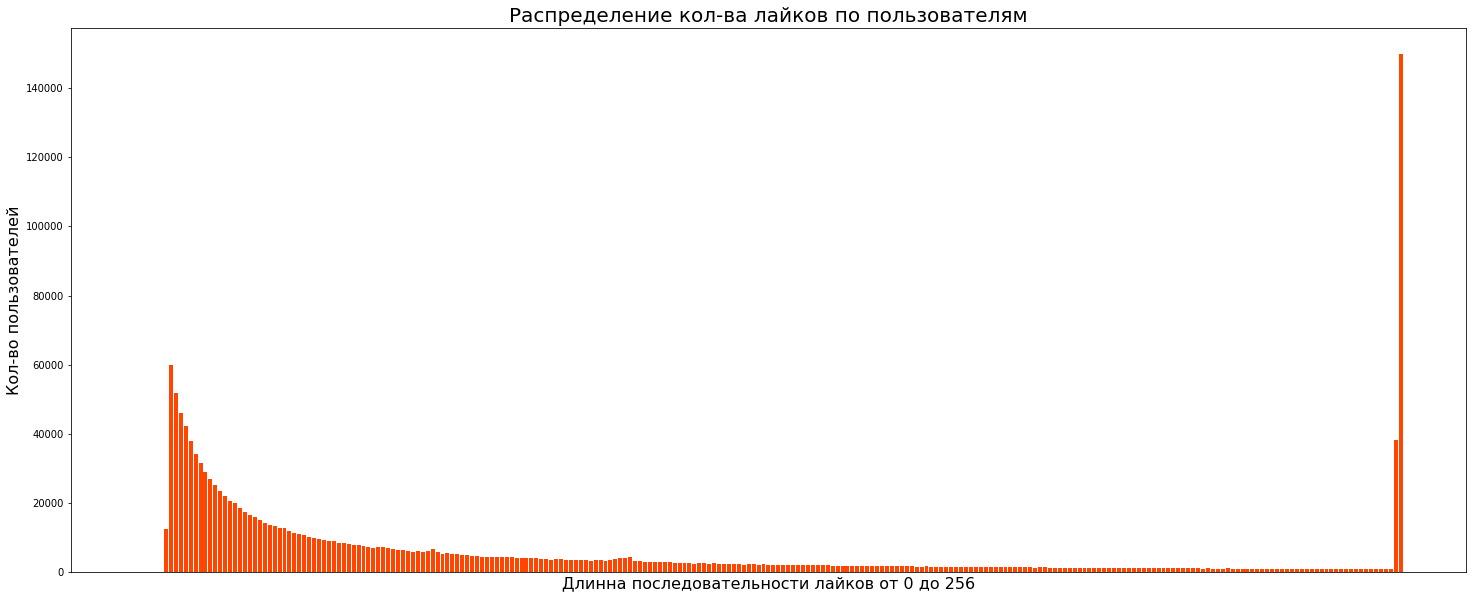

In [18]:
# пострим распределение кол-ва лайков по пользователям
len_likes = {}
for i in range(max_len+1):
    len_likes[i] = 0

for i in range(len(likes)):
    len_likes[len(likes[i])] += 1

x, y = [], []
for i in range(max_len+1):
    x.append(str(i))
    y.append(len_likes[i])

# построение графика
plt.figure(figsize=(25,10))
plt.title('Распределение кол-ва лайков по пользователям', fontsize=20)
plt.bar(x, y, color = '#FF4500')
plt.xlabel(f'Длинна последовательности лайков от 0 до {max_len}', fontsize=16)
plt.xticks([])
plt.ylabel('Кол-во пользователей', fontsize=16)
plt.show()

In [21]:
# обучение векторных представлений треков
embeddings = Word2Vec(likes, vector_size=300, window=4, min_count=1, workers=4)

Сделаю submit следующим образом:  
1) Посчитаю средние эмбединги для каждого пользователя  
2) Найду топ 357 ближайших треков по косинусной мере(именно 357 треков, чтобы смогли гарантированно порекомендовать 100 треков)  
3) Вычту треки, которые пользователь уже слушал  

In [22]:
# считаем средний эмбединг пользователя в test
average_emb = []

with open('test') as f:
    lines = f.readlines()
    for line in lines:
        sum = np.zeros(300)
        tracks = line.strip().split(' ')
        for i in range(len(tracks)):
            if tracks[i] in embeddings.wv:
                sum += embeddings.wv[tracks[i]]
        average_emb.append(sum/len(tracks))

In [ ]:
# запомним треки, которые пользователь уже слушал
likes_test = []
with open('test') as f:
    lines = f.readlines()
    for line in lines:
        tracks = line.strip().split(' ')
        likes_test.append(tracks)

In [ ]:
# находим топ похожих треков и вычитаем уже прослушанные
result = []
for person in tqdm(range(len(average_emb))):
    similar = embeddings.wv.most_similar(average_emb[person],topn=357)
    rec = []
    for i in range(len(similar)):
        if similar[i][0] not in likes[person] and len(rec) != 100:
          rec.append(similar[i][0])
        if len(rec) == 100:
          break
    result.append(' '.join([x for x in rec]) + '\n')

In [ ]:
# записываем результат
with open('result', 'w') as f:
    f.writelines(result)